In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from datetime import datetime
import re
from textblob import TextBlob
from nltk.translate.bleu_score import sentence_bleu
from transformers import DistilBertModel,DistilBertTokenizer
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from tqdm import tqdm

In [2]:
PATH_ROOT = "/home/shaul/workspace/GitHub/SOTA/"

In [3]:
cd {PATH_ROOT}

/home/shaul/workspace/GitHub/SOTA


In [4]:
for i, file in enumerate(glob.glob('data/raw_data/*.csv')):
    if i==0:
        df = pd.read_csv(file, index_col = 0)
        df['dataset'] = file[5:-4].lower()
    else:
        temp = pd.read_csv(file, index_col = 0)
        temp['dataset'] = file[5:-4].lower()
        df = pd.concat((df,temp),axis = 0)
df['random'] = df.dataset.apply(lambda x: 'random' in  x).astype(int)
df['duration'] = pd.to_datetime(df.SubmitTime)-pd.to_datetime(df.AcceptTime)


df = df.drop(['HITId','HITTypeId', 'Title', 'Description', 'Keywords',
       'RequesterAnnotation', 'AssignmentDurationInSeconds', 'AssignmentId','AssignmentStatus','AcceptTime', 'SubmitTime','AutoApprovalTime', 'ApprovalTime', 'RejectionTime','RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate','Last30DaysApprovalRate', 'Last7DaysApprovalRate','Approve', 'Reject'],axis = 1)

df.columns = ['annotator', 'text1','text2','label','dataset','random','duration']

df.label = df.label.apply(lambda x:x[0]).astype(int)

df = df.reset_index()
df['total_seconds'] = [int(df['duration'][i].total_seconds()) for i in range(df.shape[0])]
df.drop(columns="index",inplace=True)
df.to_csv('data/combined_dataset.csv')

In [87]:
df = pd.read_csv("data/combined_dataset.csv")
df.drop(columns="Unnamed: 0", inplace=True)

In [88]:
df = df[df['dataset'] == 'raw_data/yelp_human']

In [89]:
df.reset_index(inplace=True)
df.drop(columns="index",inplace=True)

In [90]:
df.head(3)

,annotator,text1,text2,label,dataset,random,duration,total_seconds
0,A8TIL9U6YHG5,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,1,raw_data/yelp_human,0,0 days 00:00:08.000000000,8
1,A3JD6IDODWJN98,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,4,raw_data/yelp_human,0,0 days 00:03:49.000000000,229
2,A2Z5WHZ0A2JJ6A,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,1,raw_data/yelp_human,0,0 days 00:00:10.000000000,10


Although I can just go straight to observe the difference between the (rudimentary approx. of) sentiment and the label score - it wouldn't be fair because the two sentences could also be semantically very different as well as be sentimentally diverging.

Therefore to better observe the phenomenon, lets highlight cases which have a very high word-overlap and see in those cases when the sentiment is different if they score high or low.

In [44]:
# Sentiment analysis pipeline
sentiment_pipe = pipeline("sentiment-analysis")

Downloading: 100%|██████████| 629/629 [00:00<00:00, 803kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 285kB/s]
Downloading: 100%|██████████| 230/230 [00:00<00:00, 150kB/s]
Downloading: 100%|██████████| 268M/268M [03:24<00:00, 1.31MB/s]


In [50]:
text1_sent = sentiment_pipe(df.text1.tolist())
text2_sent = sentiment_pipe(df.text2.tolist())

In [92]:
df['dif_sent'] = abs(np.array([x['score'] if x['label']=="POSITIVE" else (-1*x['score']) for x in text1_sent]) \
                     - np.array([x['score'] if x['label']=="POSITIVE" else (-1*x['score']) for x in text2_sent]))

In [93]:
df.head(5)

,annotator,text1,text2,label,dataset,random,duration,total_seconds,dif_sent
0,A8TIL9U6YHG5,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,1,raw_data/yelp_human,0,0 days 00:00:08.000000000,8,1.999669
1,A3JD6IDODWJN98,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,4,raw_data/yelp_human,0,0 days 00:03:49.000000000,229,1.999669
2,A2Z5WHZ0A2JJ6A,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,1,raw_data/yelp_human,0,0 days 00:00:10.000000000,10,1.999669
3,A3TKUXUTDX6FBF,"the food was mediocre at best , far too greasy...","the food was great , not too greasy and cooked...",4,raw_data/yelp_human,0,0 days 00:00:08.000000000,8,1.999553
4,A24JKHC4HTY6CD,"the food was mediocre at best , far too greasy...","the food was great , not too greasy and cooked...",3,raw_data/yelp_human,0,0 days 00:05:44.000000000,344,1.999553


In [30]:
pairs = []
for index, row in df.iterrows():
    first_sentence_tokens = row['text1'].strip().split()
    second_sentence_tokens = row['text2'].strip().split()
    pairs.append((first_sentence_tokens, second_sentence_tokens))

In [31]:
scores_bleu1 = []
for first_sentence_tokens, second_sentence_tokens in pairs:

    score_bleu1 = sentence_bleu([first_sentence_tokens], second_sentence_tokens, weights=(1, 0, 0, 0))
    scores_bleu1.append(score_bleu1)

print(np.mean(scores_bleu1))
print(np.std(scores_bleu1))



0.2243693426144784
0.28016333413937694
0.5199988650460751
0.26093350307531066


In [94]:
df['bleu_score_1'] = scores_bleu1

count    3000.000000
mean        1.628235
std         0.738895
min         0.000005
25%         1.933680
50%         1.997143
75%         1.999333
max         1.999704
Name: dif_sent, dtype: float64


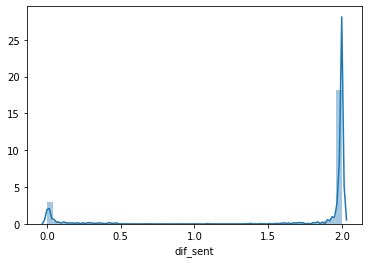

In [95]:
print(df.dif_sent.describe())
sns.distplot(df.dif_sent);

count    3000.000000
mean        0.519999
std         0.260977
min         0.000000
25%         0.298280
50%         0.536769
75%         0.750000
max         1.000000
Name: bleu_score_1, dtype: float64


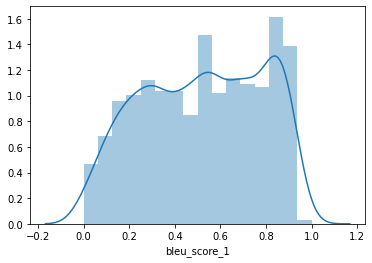

In [96]:
print(df.bleu_score_1.describe())
sns.distplot(df.bleu_score_1);

In [97]:
df.loc[df['bleu_score_1'] > 0.8][:12]

,annotator,text1,text2,label,dataset,random,duration,total_seconds,dif_sent,bleu_score_1
0,A8TIL9U6YHG5,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,1,raw_data/yelp_human,0,0 days 00:00:08.000000000,8,1.999669,0.846154
1,A3JD6IDODWJN98,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,4,raw_data/yelp_human,0,0 days 00:03:49.000000000,229,1.999669,0.846154
2,A2Z5WHZ0A2JJ6A,the calzones are awesome and the lunch special...,the calzones are awful and the lunch special t...,1,raw_data/yelp_human,0,0 days 00:00:10.000000000,10,1.999669,0.846154
6,A3V8FN8YW3YHAV,"had one mediocre meal and said , `` we 'll try...","had one great meal and said , `` we 'll try ag...",2,raw_data/yelp_human,0,0 days 00:00:07.000000000,7,1.980535,0.857143
7,A3BCGN11HDM8QR,"had one mediocre meal and said , `` we 'll try...","had one great meal and said , `` we 'll try ag...",2,raw_data/yelp_human,0,0 days 00:00:05.000000000,5,1.980535,0.857143
8,A2BA1R9MAHHWJH,"had one mediocre meal and said , `` we 'll try...","had one great meal and said , `` we 'll try ag...",4,raw_data/yelp_human,0,0 days 00:02:26.000000000,146,1.980535,0.857143
9,AFQIHS5XX58NR,the food is worse than you find in the freezer...,the food is way better than you find in the fr...,3,raw_data/yelp_human,0,0 days 00:00:05.000000000,5,1.997567,0.866667
10,A2WYGPR0ECWJFZ,the food is worse than you find in the freezer...,the food is way better than you find in the fr...,1,raw_data/yelp_human,0,0 days 00:00:32.000000000,32,1.997567,0.866667
11,A2JUO3H5VTEEM1,the food is worse than you find in the freezer...,the food is way better than you find in the fr...,2,raw_data/yelp_human,0,0 days 00:00:05.000000000,5,1.997567,0.866667
27,A3IDU0PGLK1H1F,my jack and coke was seriously lacking .,my jack and coke was seriously popping .,4,raw_data/yelp_human,0,0 days 00:00:11.000000000,11,1.996973,0.875000


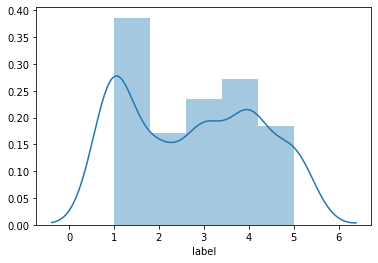

In [67]:
sns.distplot(df[(df['bleu_score_1'] > 0.8) & (df['dif_sent'] > 1.9)].label);

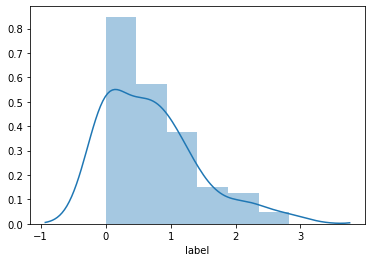

In [71]:
sns.distplot(df[(df['bleu_score_1'] > 0.8) & (df['dif_sent'] > 1.9)].groupby('annotator')['label'].std());

In [138]:
df[(df['bleu_score_1'] > 0.8) & (df['dif_sent'] > 1.9)].groupby('annotator')['label'].std().describe()

count    85.000000
mean      0.693996
std       0.711571
min       0.000000
25%       0.000000
50%       0.577350
75%       1.060660
max       2.828427
Name: label, dtype: float64

In [134]:
df[(df['bleu_score_1'] > 0.8) & (df['dif_sent'] > 1.9)].groupby('annotator')['label'].std().dropna().sort_values()[:]

annotator
A2JUO3H5VTEEM1    1.251666
A3746TDKYH8SJ9    1.253566
A23U040IB98A2S    1.414214
AE7UECBR4D5E6     1.414214
A3IDU0PGLK1H1F    1.527525
A2FJDUJZ38B9XL    1.602082
A14UJPO621M1X0    1.618347
A2G44A4ZPWRPXU    1.732051
A2YHF6Y4E55VHV    2.121320
A2BA1R9MAHHWJH    2.121320
A2RKUDGK5PQ44X    2.121320
A2MV1325939NBM    2.309401
A9ZM1P6LBW79      2.309401
A1BDH3O29OKARK    2.828427
A848G3C44BRC4     2.828427
Name: label, dtype: float64

In [126]:
df[(df['bleu_score_1'] > 0.8) & (df['dif_sent'] > 1.9) & (df['annotator'] == 'A2RKUDGK5PQ44X')]

,annotator,text1,text2,label,dataset,random,duration,total_seconds,dif_sent,bleu_score_1
389,A2RKUDGK5PQ44X,these two women are professionals .,these two women are not professionals .,1,raw_data/yelp_human,0,0 days 00:00:10.000000000,10,1.998976,0.857143
519,A2RKUDGK5PQ44X,i may just post pictures to prove their shoddy...,i may just post pictures to prove their high q...,4,raw_data/yelp_human,0,0 days 00:00:19.000000000,19,1.998306,0.833333


In [137]:
df[(df['bleu_score_1'] > 0.8) & (df['dif_sent'] > 1.9) & (df['annotator'] == 'A23U040IB98A2S')]

,annotator,text1,text2,label,dataset,random,duration,total_seconds,dif_sent,bleu_score_1
632,A23U040IB98A2S,this one is not on the ball .,this one is right on the ball .,3,raw_data/yelp_human,0,0 days 00:00:29.000000000,29,1.996484,0.875
2630,A23U040IB98A2S,oj and jeremy did a great job !,oj and jeremy did a terrible job !,5,raw_data/yelp_human,0,0 days 00:00:18.000000000,18,1.997165,0.875


In [136]:
i = 2139

print(df.iloc[i].text1)
print(df.iloc[i].text2)

nice for me to go and work and have a great breakfast !
nice for me to go and work and have a bad breakfast !
